Работу выполнил : Батутин Андрей , DataScientist  
26.12.24г.  

Задача:
определение стат значимости результата первого боксерского поединка Бивол-Бетербиев

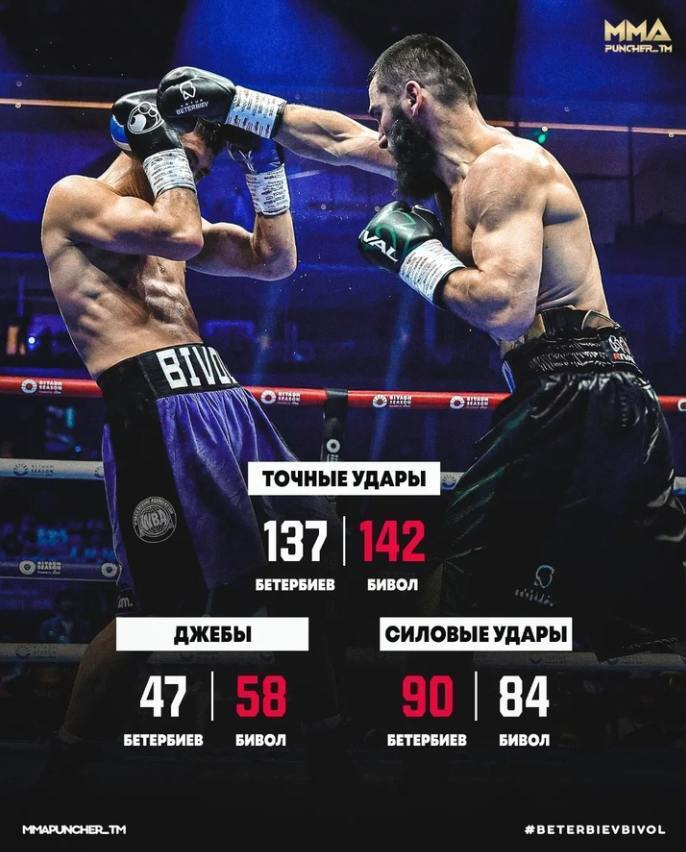

In [1]:
from IPython.display import Image
Image("/Users/andrejbatutin/DS/BIVOL-BTR.jpg", width=1000, height=400)

In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, uniform
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

Формулируем гипотезу:
Н0: Разница в 5 ударов за бой не значима.Бивол получил эту разницу случайно  
Н1: Разница в 5 ударов за бой значима,Бивол "вырвал" эти ударов не случайно,за счет мастерства и превосходства над соперником

Статистика по нанесенным ударам

In [4]:
import pandas as pd
data_total_punches = {
    "Beterviev": [4, 6, 13, 10, 7, 9, 17, 12, 13, 10, 21, 15],
    "Bivol": [14, 12, 12, 11, 11, 9, 13, 7, 15, 9, 15, 14],
}
df_total_punches = pd.DataFrame(data_total_punches)
df_total_punches


,Beterviev,Bivol
0,4,14
1,6,12
2,13,12
3,10,11
4,7,11
5,9,9
6,17,13
7,12,7
8,13,15
9,10,9


In [5]:
print(f'Бивол нанес на {(df_total_punches['Bivol'].sum() - df_total_punches['Beterviev'].sum())} ударов больше за бой')
print(f'Бивол {df_total_punches['Bivol'].sum()} / {df_total_punches['Beterviev'].sum()} Бетербиев')
print('Давайте найдем,закономерно ли это')
print(f'Разница средних за все 12 раундов {np.round((df_total_punches['Bivol'].mean() - df_total_punches['Beterviev'].mean()),3)}')

Бивол нанес на 5 ударов больше за бой
Бивол 142 / 137 Бетербиев
Давайте найдем,закономерно ли это
Разница средних за все 12 раундов 0.417


Используем ттест Стьюдента при уровне значимости 0.05

In [6]:
t_statistic, p_value = stats.ttest_ind(df_total_punches['Bivol'].values, df_total_punches['Beterviev'].values)
print('p_value',np.round(p_value,3))

p_value 0.794


Не можем отклонить нулевую гипотезу в прямую из за слабой мощности по причине недостотаточной выборки

Расчитаем фактическое МДЕ,которое можем задетектировать,с выборкой в 12.
Для этого,обьеденим дисперсию

In [7]:
print('Дисперсия',np.round(df_total_punches.values.var(),3))
print('Стд.отклонение',np.round(df_total_punches.values.std(),3))


Дисперсия 13.651
Стд.отклонение 3.695


In [8]:
#определить эффект по набору выборки
n = 12
Var_contrl = 13.65
np.round((-(-1.96+(-0.842)) * np.sqrt((4 * Var_contrl /n))),2)

5.98

In [9]:

x1 = 11.83
x2 = 11.41
dif = x1-x2
s1 = 2.55
s2 = 4.81
n1 = 12
n2 = 12
all_dif = []
curent_a = pd.Series(np.random.normal(loc=x1,scale=s1,size=n1))
curent_b = pd.Series(np.random.normal(loc=x2,scale=s2,size=n2))
all_data = pd.concat([curent_a]+[curent_b])
count = 0
iterations = 10000
all_dif = []
for i in range(iterations):
    sub_a = all_data.sample(12,replace=True).mean()
    sub_b = all_data.sample(12,replace=True).mean()
    cur_dif = sub_a-sub_b
    all_dif.append(cur_dif)
    if abs(cur_dif) >= dif:
        count += 1
print(f'Фактическая мощность(способность обнаружить эффект там,где он действительно есть) при 12 наблюдениях {np.round(1- count/iterations,3)}')
print('Поэтому слепо доверять pvalue без дизайна АБ теста нельзя(хоть и такой тест,лучше чем отстутствие любого (с) Карпов.')

Фактическая мощность(способность обнаружить эффект там,где он действительно есть) при 12 наблюдениях 0.261
Поэтому слепо доверять pvalue без дизайна АБ теста нельзя(хоть и такой тест,лучше чем отстутствие любого (с) Карпов.


Выборка 12 позволяет нам задетектировать разницу средних только более ~ 6 ударов.Но не 0.41
Соотвественно,расчитаем необходимый размер выборки

In [ ]:
alpha = 0.05  # уровень значимости
power = 0.80  # мощность теста
delta = 0.417    # ожидаемая разница между группами
sigma = 3.695  # стандартное отклонение

# Рассчитайте размер выборки
sample_size = sm.stats.tt_ind_solve_power(effect_size=delta/sigma, 
                                            nobs1=None, 
                                            alpha=alpha, 
                                            power=power, 
                                            alternative='two-sided')

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 1233


Отклоним нулевую гипотезу с помощью доверительного интервала:
- Если разницы между бойцами нет, то разница средних кол-ва ударов за раунд является 0.
- Если 0 не находится в диапазоне дов.интревала - значит отклоняем гипотезу о равенстве боксеров

(0.4149415680849111, 0.4207833305363379)
Отклоняем нулевую гипотезу,так как с 95% вероятностью - Ноль не является истиным значением разницы средних


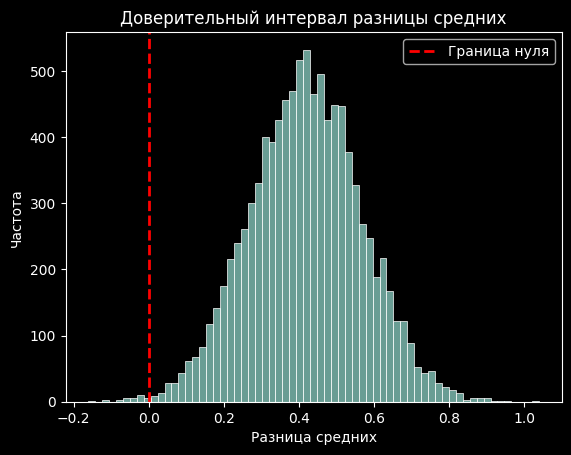

In [11]:
list_diff = []
for i in range(10000):
    sub_a = df_total_punches['Bivol'].sample(1233,replace=True).mean()
    sub_b = df_total_punches['Beterviev'].sample(1233,replace=True).mean()
    list_diff.append(sub_a - sub_b)
overall = pd.Series(list_diff)
print(st.t.interval(confidence=0.95, df=len(overall)-1, loc=np.mean(overall), scale=st.sem(overall)))
print('Отклоняем нулевую гипотезу,так как с 95% вероятностью - Ноль не является истиным значением разницы средних')
sns.histplot(overall)
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2, label='Граница нуля')
plt.title('Доверительный интервал разницы средних')
plt.xlabel('Разница средних')
plt.ylabel('Частота')
plt.legend()
plt.show()

Проверим гипотезу с помощью Монте-Карлов(генерируем процесс)

pvalue 0.0158
Отклоняем нулевую гипотезу,так как наблюдаемая разница РАВНЫМИ распределениями встречается реже чем в 5% случаях


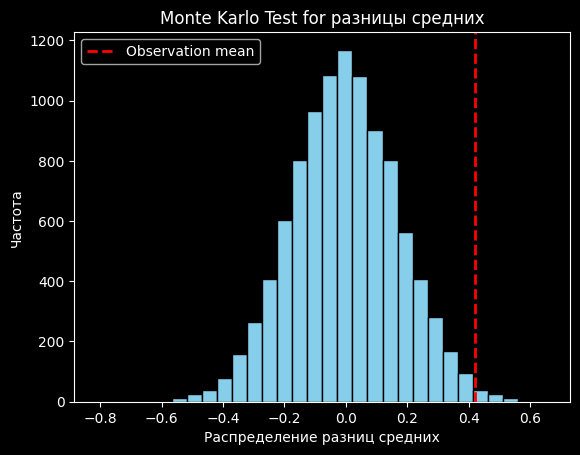

In [12]:

x1 = 11.83
x2 = 11.41
dif = x1-x2
s1 = 2.55
s2 = 4.81
n1 = 12
n2 = 12
all_dif = []
curent_a = pd.Series(np.random.normal(loc=x1,scale=s1,size=n1))
curent_b = pd.Series(np.random.normal(loc=x2,scale=s2,size=n2))
all_data = pd.concat([curent_a]+[curent_b])
count = 0
iterations = 10000
all_dif = []
for i in range(iterations):
    sub_a = all_data.sample(1233,replace=True).mean()
    sub_b = all_data.sample(1233,replace=True).mean()
    cur_dif = sub_a-sub_b
    all_dif.append(cur_dif)
    
    if abs(cur_dif) >= dif:
        count += 1
print('pvalue',count/iterations)
print('Отклоняем нулевую гипотезу,так как наблюдаемая разница РАВНЫМИ распределениями встречается реже чем в 5% случаях')
all_dif = pd.Series(all_dif)
plt.hist(all_dif, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=dif, color='red', linestyle='dashed', linewidth=2, label='Observation mean')
plt.title('Monte Karlo Test for разницы средних')
plt.xlabel('Распределение разниц средних')
plt.ylabel('Частота')
plt.legend()
plt.show()

Проведем Ттест Стьюдента(из кода выше) с расчетной мощностью 80% увеличив выборки эмпирически до 1233 (раундов)

In [20]:
BIVOL = df_total_punches['Bivol'].sample(1233,replace=True)
BTR = df_total_punches['Beterviev'].sample(1233,replace=True)
t_statistic, p_value = stats.ttest_ind(BIVOL, BTR)
print('pvalues',np.round(p_value,3))
print('Ттесту сверху не хватило мощности увидеть значимость,отклоняем нулевую гипотезу')

pvalues 0.012
Ттесту сверху не хватило мощности увидеть значимость,отклоняем нулевую гипотезу


Проверим через распределение pvalue и qq-plot.  
Если различия нет,распределение примет форму нормального.  
Если различие есть - распределение станет скошеным

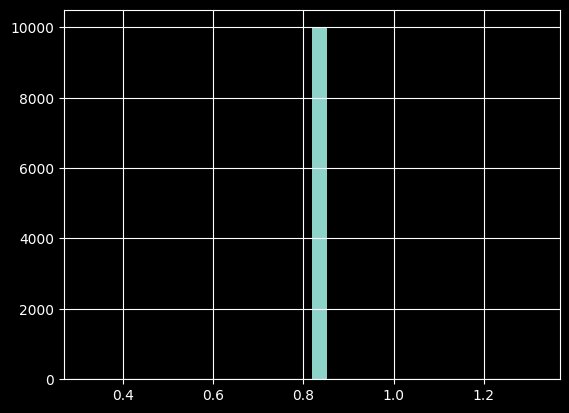

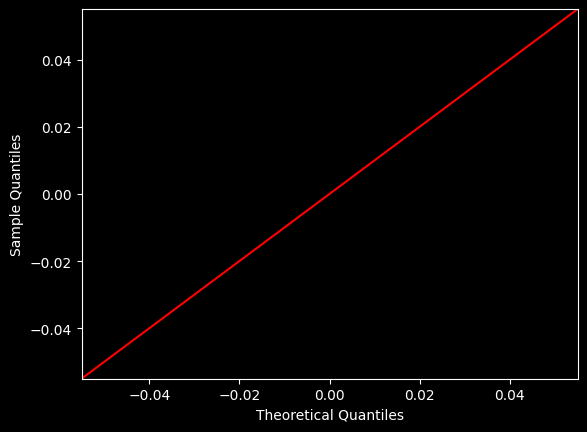

In [14]:
l_pval = []
for i in range(10000):
    Bivol = all_data.sample(1233,replace=True).mean()
    Bete = all_data.sample(1233,replace=True).mean()
    t_statistic, p_value = stats.ttest_ind(curent_a, curent_b)
    l_pval.append(p_value)
pd.Series(l_pval).hist(bins=30)
plt.show()
qqplot(pd.Series(l_pval),uniform,fit=True,line="45")
plt.show()

Теперь можем сказать,что Бивол нанес больше ударов за бой не случайно с погрешностью в 5%!  при условии что они проведут 1233 похожих на имеющиеся раундов.  
По имеющемуся набору данных ни о какой стат.значимости говорить нельзя


Не смотря на разницу в 5 ударов - Бетербиев выбросил  682 удара против 423 Бивола  
Разбил блок и лицо Бивола силовыми ударами 90 - 84 и доминировал весь бой,заслужив честную победу.